# AutoRegression MovingAverage Model on Stock Prices

### Imports

In [124]:
import pandas as pd
import numpy as np
import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime 
plt.style.use('bmh')

In [110]:
df = pd.read_csv('SPY.csv')

df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-05-04,211.229996,212.020004,211.100006,211.320007,191.227142,70927200
1,2015-05-05,211.029999,211.460007,208.729996,208.899994,189.037262,113326200
2,2015-05-06,209.559998,209.929993,206.759995,208.039993,188.259018,135060200
3,2015-05-07,207.919998,209.380005,207.520004,208.869995,189.010117,88244900
4,2015-05-08,210.880005,211.860001,210.779999,211.619995,191.498642,155877300
5,2015-05-11,211.570007,211.889999,210.520004,210.610001,190.584671,75708100
6,2015-05-12,209.610001,210.630005,208.619995,209.979996,190.014572,119727600
7,2015-05-13,210.470001,211.220001,209.740005,210.020004,190.050766,94667900
8,2015-05-14,211.240005,212.320007,210.910004,212.210007,192.032532,95934000
9,2015-05-15,212.440002,212.610001,211.860001,212.440002,192.240662,76510100


## Preprocessing Data

### Datetime Conversion

In [111]:
# Datetime conversion
df['Date'] = pd.to_datetime(df.Date)

# Setting the index
df.set_index('Date', inplace=True)

# Dropping any NaNs
df.dropna(inplace=True)

### Scaling

In [112]:
scaler = MinMaxScaler()

df = pd.DataFrame(scaler.fit_transform(df),
                  index=df.index,
                  columns=df.columns)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


### Dropping

In [113]:
df = df[['Close']]

## Visualizing the Data

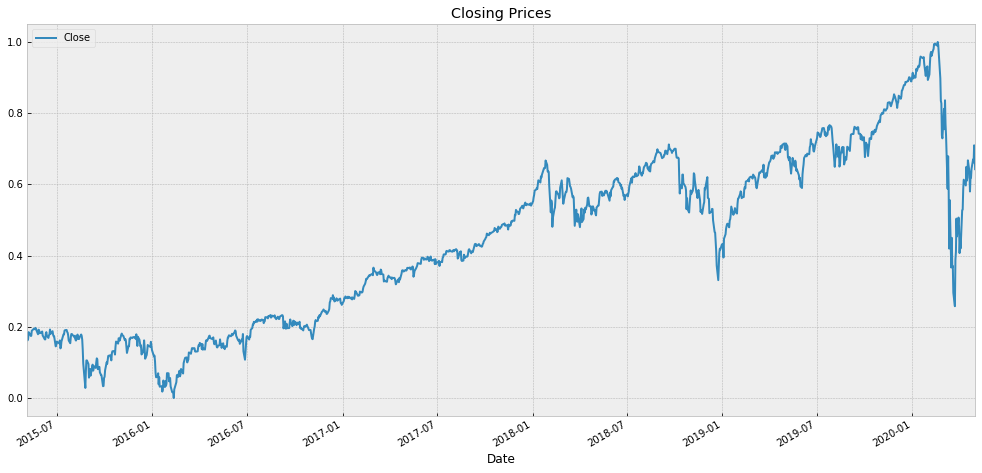

In [114]:
df.plot(figsize=(17,8), title='Closing Prices');

## Detrending

### Differencing the Data

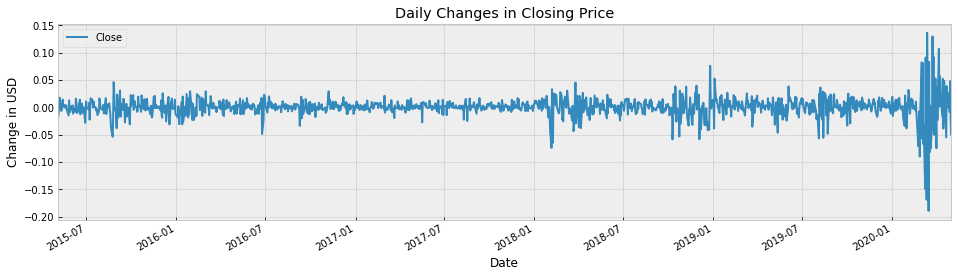

Testing for Stationarity
	P-value: 1.7720335724722586e-18


In [115]:
# Differencing
df_diff = df.diff(1).dropna()

# Plotting
df_diff.plot(figsize=(16,4), title="Daily Changes in Closing Price")
plt.ylabel("Change in USD")
plt.show()

# Stationarity Testing
results = adfuller(df_diff.iloc[:,0].values)
print(f"Testing for Stationarity\n\tP-value: {results[1]}")

### ACF and PACF

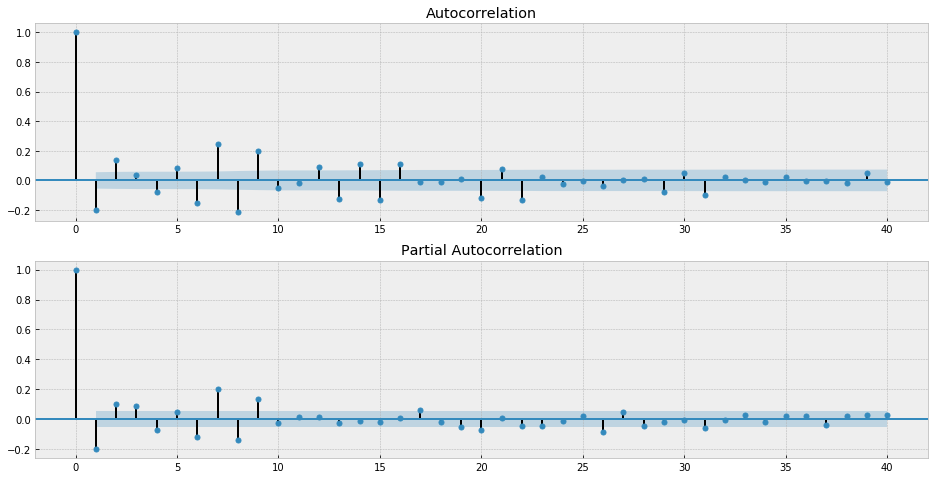

In [116]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))
plot_acf(df_diff, ax=ax1, lags=40)
plot_pacf(df_diff, ax=ax2, lags=40)
plt.show()

## Parameter Search
Using a function to find the best parameters for the ARMA model

In [125]:
# Assigning variables to the p and q values
p = q = range(0,5)

# Finding all possible combinations of p and q
pq = list(itertools.product(p, q))

def param_search(model, data, pq):
    """
    Loops through each iteration of the model and returns the best performing parameter
    """
    
    # Empty dictionary containing the combination and AIC score
    lst = {}
    
    # Loop to find the best combination
    for comb in tqdm(pq):
        try:
            # Instantiating the model
            mod = model(data,
                        order=comb)
            
            # Fitting the model
            output = mod.fit()
            
            # Appending to the list
            lst[comb] = output.aic
        
        except:
            continue
    
    # Returning the combination with lowest AIC score
    return 

## Modeling

#### Train, Test, Splitting

In [117]:
# Splitting 80/20
index = round(len(df)*.80)

train = df.iloc[:index]
test = df.iloc[index:]

### Fitting the Model

In [118]:
model = ARMA(train,
             order=(1,0))


output = model.fit()

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


### Summary and Diagnostics

In [119]:
print(output.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 1007
Model:                     ARMA(1, 0)   Log Likelihood                2934.435
Method:                       css-mle   S.D. of innovations              0.013
Date:                Wed, 27 May 2020   AIC                          -5862.871
Time:                        12:48:14   BIC                          -5848.127
Sample:                             0   HQIC                         -5857.269
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.4046      0.166      2.443      0.015       0.080       0.729
ar.L1.Close     0.9983      0.002    635.677      0.000       0.995       1.001
                                    Roots       

### Forecasting

In [120]:
# Getting Forecast and Confidence Intervals
forecast = output.forecast(len(test))
fc       = forecast[0]
conf     = forecast[-1]

# Putting the Data into a Pandas Series
fc_series = pd.Series(fc, index=test.index)
up_conf   = pd.Series(conf[:, 0], index=test.index)
low_conf  = pd.Series(conf[:, 1], index=test.index)

### Validating

In [121]:
predictions = output.predict(start=1, end=len(train))

preds = pd.Series(predictions.values, index=train.index)

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


### Plotting

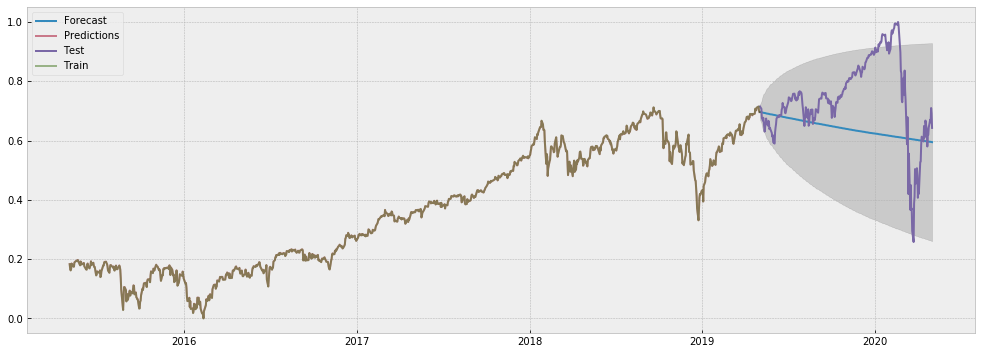

In [122]:
plt.figure(figsize=(17,6))

# Forecast plot
plt.plot(fc_series, label='Forecast')
# Confidence Interval shaded
plt.fill_between(low_conf.index, low_conf, up_conf, color='k', alpha=.15)
# Predictions against Training data
plt.plot(preds, label='Predictions', alpha=.5)

# Train and Test Plot
plt.plot(test, label='Test')
plt.plot(train, label='Train', alpha=.5)

# Plotting
plt.legend()
plt.show()